In [1]:
# !pip install torch
# !pip install torchvision

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [76]:
transform_train = transforms.Compose(
    [transforms.ToTensor()])

transform_test = transforms.Compose([
    transforms.ToTensor()])

batch_size = 32

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [77]:
print(f'train dataset len: {len(trainset)}, test dataset len: {len(testset)}')

train dataset len: 50000, test dataset len: 10000


In [78]:
imgs, labels = next(iter(trainloader))
print(f'shape of img: {imgs.shape}')

shape of img: torch.Size([32, 3, 32, 32])


In [79]:
imgs.max(), imgs.min()

(tensor(1.), tensor(0.))

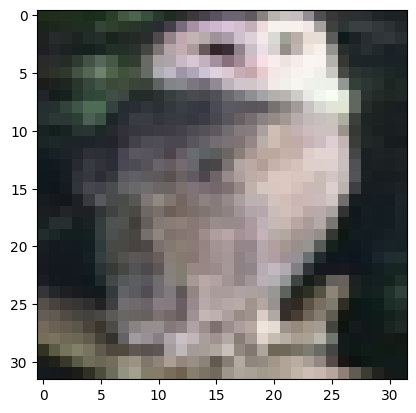

In [82]:
plt.imshow(imgs[0].permute(1, 2, 0))

In [2]:
device = torch.device('cuda')

In [96]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        # ((h + 2p - k) / s) + 1
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, hidden_dim, kernel_size=4, stride=2, padding=1), # (batch, 3, 32, 32) -> (400, 16, 16)
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=4, stride=2, padding=1), # (800, 8, 8)
            nn.ReLU(),
            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=2, padding=1), # (1600, 4, 4)
            nn.ReLU()
        )

        self.flattened_size = (hidden_dim * 4) * (4 * 4) # (1600 hidden dim * 4h * 4w)

        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, self.flattened_size)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, input_dim, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h1 = self.encoder(x)
        # h1.size(0) is the batch, remains unchanged
        h1 = h1.view(h1.size(0), -1) # -1 flattens it as (batch_size, 1600, 4, 4) -> (batch_size, 1600 * 4 * 4)
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = self.fc2(z)
        h2 = h2.view(h2.size(0), 1600, 4, 4) # in reverse (batch_size(32) * 1600 * 4 * 4) -> (batch_size, 1600, 4, 4)
        return self.decoder(h2)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        decoded = self.decode(z)
        return decoded, mu, logvar


In [97]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [98]:
# Training the VAE
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

In [99]:
vae = VAE(3, 400, 20).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
for epoch in range(1, 11):
    train(vae, trainloader, optimizer, epoch)

Epoch 1, Loss: 1931.8746907421876
Epoch 2, Loss: 1840.7958203515625
Epoch 3, Loss: 1838.4531154296874
Epoch 4, Loss: 1837.150028359375
Epoch 5, Loss: 1836.1425916796875
Epoch 6, Loss: 1835.2396312109374
Epoch 7, Loss: 1834.363540703125
Epoch 8, Loss: 1833.7825566796876
Epoch 9, Loss: 1833.20780375
Epoch 10, Loss: 1832.98307625


In [100]:
# VAE Architecture
class FCVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(FCVAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [101]:
def loss_FCVAE_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [102]:
def train_FCVAE(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_FCVAE_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

In [103]:
# Load MNIST dataset and run the training
transform = transforms.ToTensor()
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

fc_vae = FCVAE(input_dim=784, hidden_dim=400, latent_dim=20).to(device)
optimizer = optim.Adam(fc_vae.parameters(), lr=1e-3)

for epoch in range(1, 11):
    train_FCVAE(fc_vae, train_loader, optimizer, epoch)

Epoch 1, Loss: 164.0859209798177
Epoch 2, Loss: 121.49232672526041
Epoch 3, Loss: 114.81116044921875
Epoch 4, Loss: 111.87091997070313
Epoch 5, Loss: 110.22179586588541
Epoch 6, Loss: 109.06566103515625
Epoch 7, Loss: 108.15121013997395
Epoch 8, Loss: 107.50160257161458
Epoch 9, Loss: 107.05181318359375
Epoch 10, Loss: 106.568490625


In [104]:
def generate_images(model, num_images=10, latent_dim=20):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim).to(device)
        # Decode these points to generate images
        generated_images = model.decode(z)
        # Has shape of (batch_size, channel, h, w)
        # Permute(1, 2, 0) IN THE FOR LOOP will show (h, w, c) since it's looping the batch

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
    for i in range(num_images):
        axs[i].imshow(generated_images[i].cpu().permute(1, 2, 0), cmap='gray')
        axs[i].axis('off')
    fig.suptitle('Convolutional VAE')
    plt.show()

In [105]:
def generate_original_images(model, num_images=10, latent_dim=20):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim).to(device)
        # Decode these points to generate images
        generated_images = model.decode(z).cpu()

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
    for i in range(num_images):
        axs[i].imshow(generated_images[i].view(28, 28), cmap='gray')
        axs[i].axis('off')
    fig.suptitle('Fully Connected VAE')
    plt.show()

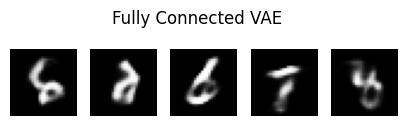

In [113]:
# fully connected vae
generate_original_images(fc_vae, num_images=5, latent_dim=20)

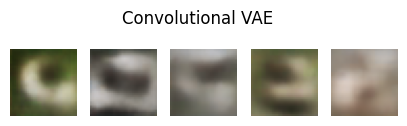

In [112]:
# conv2d vae
generate_images(vae, 5, 20)

In [43]:
def interpolate_and_generate(vae, img1, img2, num_steps=10):
    vae.eval()
    img1, img2 = img1.to(device), img2.to(device)
    
    # encode the images into latent space
    with torch.no_grad():
        mu1, logvar1 = vae.encode(img1)
        mu2, logvar2 = vae.encode(img2)
    
        z1 = vae.reparameterize(mu1, logvar1)
        z2 = vae.reparameterize(mu2, logvar2)

    # decode a combination between the two images
    # 0 will be the full first image (1 - 0) * z1 + 0 * z2 = z1
    # 1 will be the full second image (1 - 1) * z1 + 1 * z2 = z2
    interpolated_images = []
    for step in np.linspace(0, 1, num_steps):
        z_interp = (1 - step) * z1 + step * z2
        with torch.no_grad():
            img_interp = vae.decode(z_interp)
        interpolated_images.append(img_interp.cpu().squeeze(0))

    fig, axes = plt.subplots(1, num_steps, figsize=(12, 3))
    for i, img in enumerate(interpolated_images):
        tmp_img = img.permute(1, 2, 0) # (3, 32, 32) to (32, 32, 3) to display
        axes[i].imshow(tmp_img)
        axes[i].axis('off')
        axes[i].set_title(f'alpha={i/(num_steps-1):.2f}')
        
    plt.tight_layout()

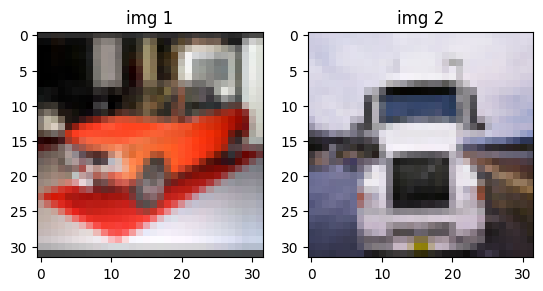

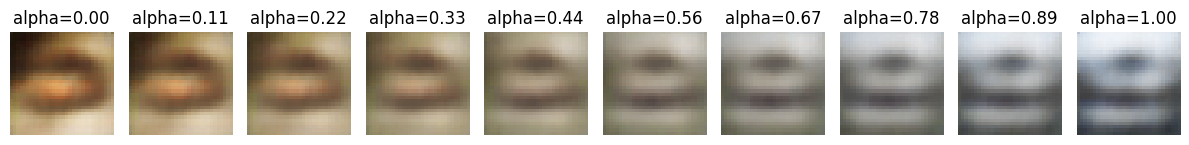

In [45]:
img1, _ = testset[np.random.randint(0, len(testset) - 1)]
img2, _ = testset[np.random.randint(0, len(testset) - 1)]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img1.permute(1, 2, 0))
axs[0].set_title('img 1')
axs[1].imshow(img2.permute(1, 2, 0))
axs[1].set_title('img 2')

img1 = img1.unsqueeze(0)
img2 = img2.unsqueeze(0)

interpolate_and_generate(vae, img1, img2, 10)

In [3]:
import glob
from torch.utils.data import Dataset
from torchvision.io import read_image

In [57]:
device = torch.device('cuda')

In [55]:
ffhq_data = glob.glob('ffhq_thumbnails\\*.png')
#ffhq_train, ffhq_test = train_test_split(ffhq_data, train_size=0.8, random_state=42, shuffle=True)

In [56]:
len(ffhq_data)

70000

In [57]:
class FFHQDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform
        print(f'Dataset initialized with {len(self.img_paths)} images.')

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = read_image(img_path)
        if self.transform:
            img_tensor = self.transform(img).to(device)
        else:
            img_tensor = img.to(device)
        return img_tensor / 255.

In [58]:
ffhq_train_dataset = FFHQDataset(ffhq_data, None)

ffhq_train_loader = torch.utils.data.DataLoader(ffhq_train_dataset, batch_size=64, shuffle=True)

Dataset initialized with 70000 images.


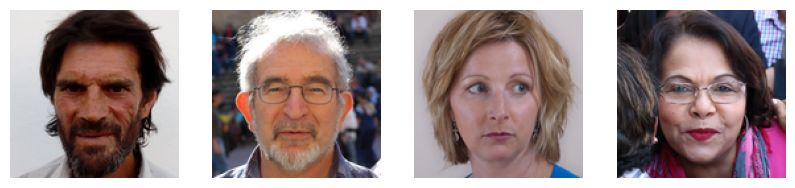

In [59]:
small_loader = torch.utils.data.DataLoader(ffhq_train_dataset, batch_size=4, shuffle=True)
small_batch = next(iter(small_loader))

fig, axs = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    axs[i].imshow(small_batch[i].cpu().permute(1, 2, 0))
    axs[i].axis('off')

In [60]:
class FFHVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(FFHVAE, self).__init__()
        # Encoder
        # ((h + 2p - k) / s) + 1
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, hidden_dim, kernel_size=4, stride=2, padding=1), # (batch, 3, 128, 128) -> (batch, 400, 64, 64)
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=4, stride=2, padding=1), # (800, 32, 32)
            nn.ReLU(),
            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=2, padding=1), # (1600, 16, 16)
            nn.ReLU(),
            nn.Conv2d(hidden_dim * 4, hidden_dim * 8, kernel_size=4, stride=2, padding=1), # (3200, 8, 8)
            nn.ReLU()
        )

        self.flattened_size = (hidden_dim * 8) * (8 * 8)

        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, self.flattened_size)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim * 8, hidden_dim * 4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, input_dim, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h1 = self.encoder(x)
        h1 = h1.view(h1.size(0), -1)
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = self.fc2(z)
        h2 = h2.view(h2.size(0), 3200, 8, 8)
        return self.decoder(h2)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        decoded = self.decode(z)
        return decoded, mu, logvar


In [61]:
def loss_FFHVAE_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 3*128*128), x.view(-1, 3*128*128), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [62]:
ffhq_vae = FFHVAE(3, 400, 20).to(device)
optimizer = optim.Adam(ffhq_vae.parameters(), lr=1e-3)

def train_FFHVAE(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_FFHVAE_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

In [63]:
for epoch in range(1, 11):
    train_FFHVAE(ffhq_vae, ffhq_train_loader, optimizer, epoch)

Epoch 1, Loss: 37508.14246428572
Epoch 2, Loss: 28319.876455357142


KeyboardInterrupt: 

In [45]:
def generate_from_latent(vae, num_samples=10):
    vae.eval()
        
    z_samples = torch.randn(num_samples, 20).to(device)

    with torch.no_grad():
        img_samples = vae.decode(z_samples)

    fig, axs = plt.subplots(1, num_samples, figsize=(12, 3))

    for i in range(num_samples):
        tmp_img = img_samples[i].cpu().permute(1, 2, 0)
        axs[i].imshow(tmp_img)
        axs[i].axis('off')
        axs[i].set_title(f'Sample {i}')

    plt.tight_layout()

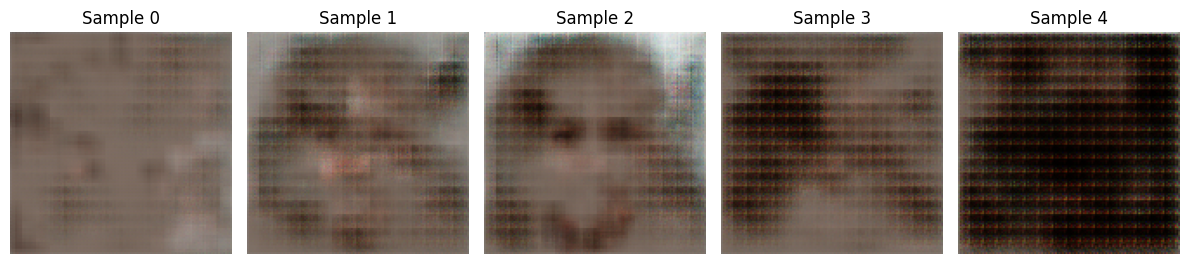

In [47]:
generate_from_latent(ffhq_vae, 5)